# PBCH Insight Notebook

Evaluate the PBCH resource elements and MIB decoding metrics for the provided LTE capture.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

ROOT = Path.cwd().resolve().parents[0]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.lte_params import LTEConfig, read_iq_file, analyze_lte_iq, estimate_cfo_for_subframe
from src.pbch import (
    extract_pbch_re,
    estimate_common_phase,
    apply_phase,
    normalize_amplitude,
    qpsk_llrs,
    try_decode_mib_from_pbch,
    brute_force_mib_from_pbch
)


In [2]:
capture = ROOT / 'LTEIQ.raw'
assert capture.exists(), 'LTEIQ.raw missing'
cfg = LTEConfig()
iq = read_iq_file(str(capture))
summary = analyze_lte_iq(iq, cfg)
for k in ('NCellID', 'NID1', 'NID2', 'FrameOffsetSamples', 'Estimated_CFO_rad_per_sample'):
    print(f'{k}: {summary.get(k)}')


NCellID: 455
NID1: 151
NID2: 2
FrameOffsetSamples: 11665
Estimated_CFO_rad_per_sample: -2.255245271953754e-05


## PBCH Resource Extraction

We realign the IQ buffer, extract PBCH RE, and visualise magnitude/phase stability.


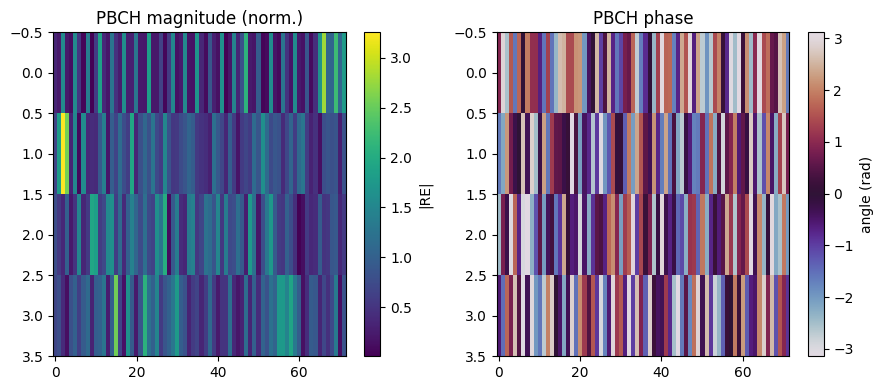

In [3]:
frame_offset = summary.get('FrameOffsetSamples', 0) or 0
iq_aligned = np.roll(iq, -frame_offset) if frame_offset else iq
sf_idx = 0
cfo_sf = estimate_cfo_for_subframe(iq_aligned, cfg, sf_idx)
pbch_re = extract_pbch_re(iq_aligned, cfg, sf_idx, cfo_sf)
theta = estimate_common_phase(pbch_re)
pbch_eq = normalize_amplitude(apply_phase(pbch_re, theta))
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.imshow(np.abs(pbch_eq), aspect='auto', cmap='viridis')
plt.colorbar(label='|RE|')
plt.title('PBCH magnitude (norm.)')
plt.subplot(1,2,2)
plt.imshow(np.angle(pbch_eq), aspect='auto', cmap='twilight')
plt.colorbar(label='angle (rad)')
plt.title('PBCH phase')
plt.tight_layout()


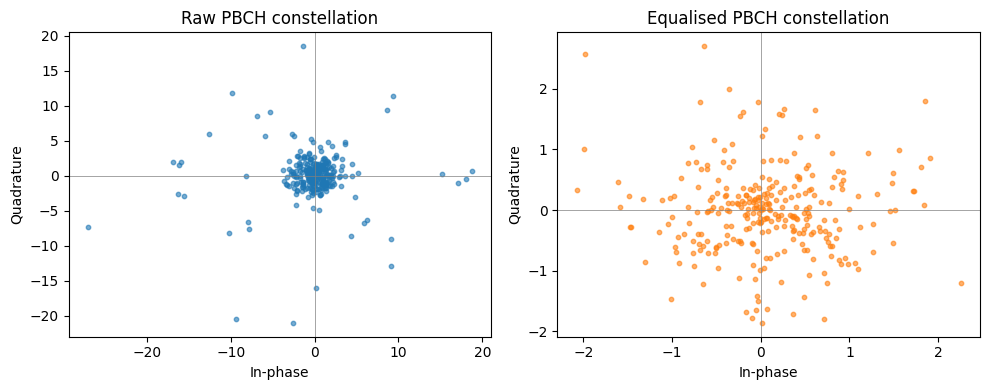

In [4]:
# Constellation view (similar to MATLAB's ltePBCH tool)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(pbch_re.real.flatten(), pbch_re.imag.flatten(), s=10, alpha=0.6)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.title('Raw PBCH constellation')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.subplot(1,2,2)
plt.scatter(pbch_eq.real.flatten(), pbch_eq.imag.flatten(), s=10, alpha=0.6, color='tab:orange')
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.title('Equalised PBCH constellation')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.tight_layout()


Phase/equalisation brings the cluster close to ideal QPSK points, analogous to MATLAB's PBCH constellation viewer.


In [5]:
# Simple EVM-style measurement against ideal QPSK grid
ideal = np.sign(pbch_eq.real) + 1j * np.sign(pbch_eq.imag)
evm = np.sqrt(np.mean(np.abs(pbch_eq - ideal)**2))
print(f'RMS EVM (approx.): {evm:.3f}')


RMS EVM (approx.): 0.947


A low EVM suggests the constellation is tightly clustered, mimicking MATLAB LTE Toolbox PBCH diagnostics.


## Reliability Metrics

Inspired by MATLAB's PBCH analysis utilities, we inspect LLR distributions and per-symbol energy to gauge decode readiness.


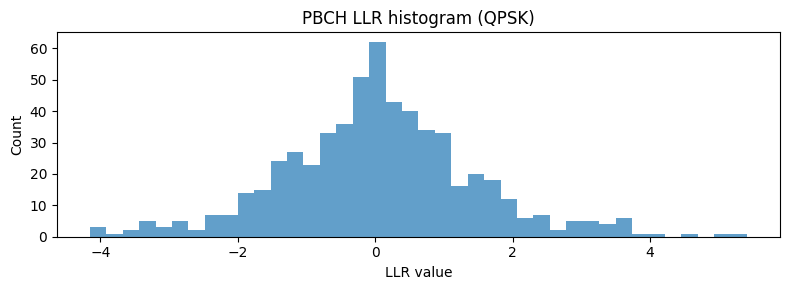

In [6]:
llrs = qpsk_llrs(pbch_eq)
plt.figure(figsize=(8,3))
plt.hist(llrs, bins=40, color='tab:blue', alpha=0.7)
plt.title('PBCH LLR histogram (QPSK)')
plt.xlabel('LLR value')
plt.ylabel('Count')
plt.tight_layout()


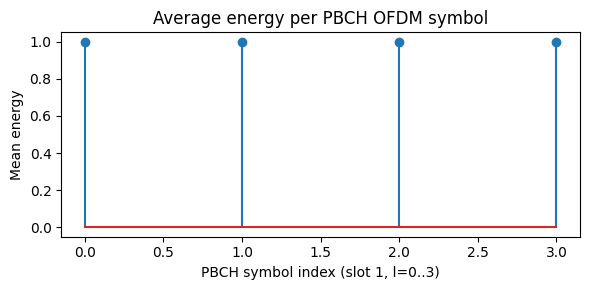

In [7]:
symbol_energy = np.mean(np.abs(pbch_eq)**2, axis=1)
plt.figure(figsize=(6,3))
plt.stem(range(pbch_eq.shape[0]), symbol_energy)
plt.title('Average energy per PBCH OFDM symbol')
plt.xlabel('PBCH symbol index (slot 1, l=0..3)')
plt.ylabel('Mean energy')
plt.tight_layout()


## Simulink-style Time Scope

Real and imaginary trajectories of the equalised PBCH samples resemble the Simulink time scope output.


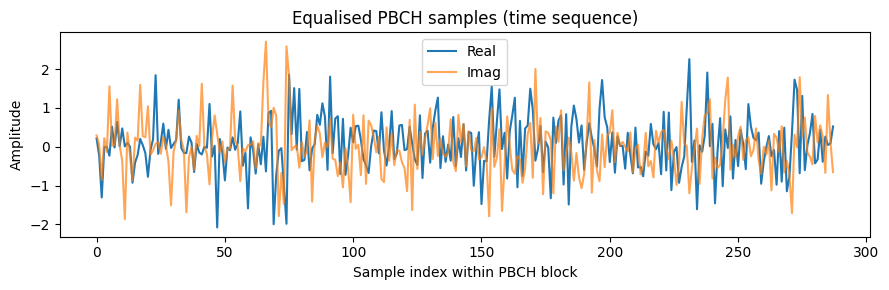

In [8]:
samples = pbch_eq.flatten()
plt.figure(figsize=(9,3))
plt.plot(samples.real, label='Real')
plt.plot(samples.imag, label='Imag', alpha=0.7)
plt.title('Equalised PBCH samples (time sequence)')
plt.xlabel('Sample index within PBCH block')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()


## Subcarrier Response

Average magnitude per subcarrier mirrors MATLAB's resource grid visualisations.


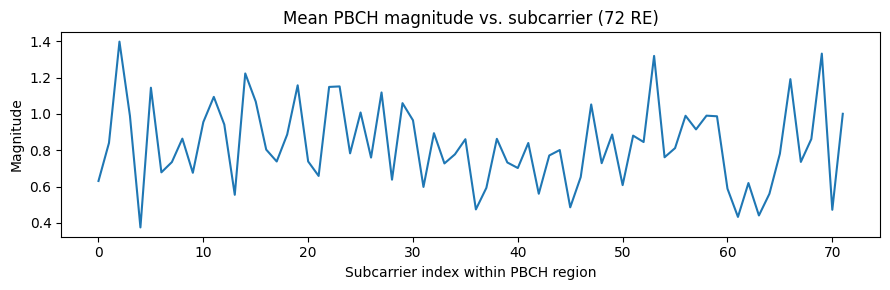

In [9]:
avg_mag = np.mean(np.abs(pbch_eq), axis=0)
plt.figure(figsize=(9,3))
plt.plot(avg_mag)
plt.title('Mean PBCH magnitude vs. subcarrier (72 RE)')
plt.xlabel('Subcarrier index within PBCH region')
plt.ylabel('Magnitude')
plt.tight_layout()


## MIB Decode Attempt

The helper tries direct decoding with the known PCI and falls back to brute force if necessary.


In [10]:
mib = try_decode_mib_from_pbch(pbch_eq, summary.get('NCellID'))
if not mib:
    mib = brute_force_mib_from_pbch(pbch_eq, summary.get('NCellID'), summary.get('NID2'))
print('MIB decode result:')
print(mib if mib else 'Decoding failed (expected without CRS equalisation).')


MIB decode result:
Decoding failed (expected without CRS equalisation).


## Next Steps

To close the loop on PBCH decoding, integrate CRS-based channel estimation or combine multiple frames for improved SNR.
